Changelog:  (Last Updated 2023-03-09)

# Probabilistic ML: Assignment 3
- **Deadline**: 2023-03-27 (March 27th 2023)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

Partner: Emmanuel Budulai      
1004070159

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [317]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [345]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [346]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [347]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [379]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    D = mean.size(0)
    eps = torch.randn(num_samples, D)
    return mean + eps * torch.exp(log_std)


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    
    D = mean.size(0)
    m = Normal(mean.expand(x.shape[0], D), torch.exp(log_std).expand(x.shape[0], D))
    return torch.sum(m.log_prob(x), axis=-1)

def batch_elbo(logprob, mean, log_std, num_samples):
    # Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    
    zs = diag_gaussian_samples(mean, log_std, num_samples)
    log_q_zs = diag_gaussian_logpdf(zs, mean, log_std)
    log_p_zs = logprob(zs)
    elbo = torch.mean(log_p_zs - log_q_zs)
    return elbo


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [380]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1])

def objective(params):
    mean, log_std = params[0], params[1]
    zs = diag_gaussian_samples(mean, log_std, num_samples_per_iter)
    log_q_zs = diag_gaussian_logpdf(zs, mean, log_std)
    log_p_zs = log_posterior_A_beat_B_10_times_1_arg(zs)
    elbo = torch.mean(log_p_zs - log_q_zs)
    return -elbo

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Almost initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


 13%|█▎        | 102/800 [00:00<00:00, 1008.68it/s]

Iteration 0 lower bound 9.249673843383789
Iteration 25 lower bound 8.695556640625
Iteration 50 lower bound 6.992348670959473
Iteration 75 lower bound 7.123967170715332
Iteration 100 lower bound 4.996440887451172
Iteration 125 lower bound 4.955852031707764
Iteration 150 lower bound 4.659704208374023
Iteration 175 lower bound 4.519958019256592


 25%|██▌       | 203/800 [00:00<00:00, 1005.44it/s]

Iteration 200 lower bound 4.271027088165283


 38%|███▊      | 304/800 [00:00<00:00, 969.02it/s] 

Iteration 225 lower bound 4.089641094207764
Iteration 250 lower bound 3.8555004596710205
Iteration 275 lower bound 3.324753999710083
Iteration 300 lower bound 3.3892393112182617
Iteration 325 lower bound 3.562819480895996
Iteration 350 lower bound 3.2896997928619385
Iteration 375 lower bound 3.199425458908081


 51%|█████     | 405/800 [00:00<00:00, 983.02it/s]

Iteration 400 lower bound 2.980292558670044


 63%|██████▎   | 504/800 [00:00<00:00, 960.07it/s]

Iteration 425 lower bound 3.206353187561035
Iteration 450 lower bound 3.3703534603118896
Iteration 475 lower bound 3.1517882347106934
Iteration 500 lower bound 2.9081220626831055
Iteration 525 lower bound 3.0421602725982666
Iteration 550 lower bound 2.9338746070861816
Iteration 575 lower bound 2.804734468460083


 76%|███████▌  | 604/800 [00:00<00:00, 970.74it/s]

Iteration 600 lower bound 3.0807945728302
Iteration 625 lower bound 3.039527177810669


100%|██████████| 800/800 [00:00<00:00, 992.07it/s]

Iteration 650 lower bound 3.1944708824157715
Iteration 675 lower bound 2.9477016925811768
Iteration 700 lower bound 2.918307304382324
Iteration 725 lower bound 2.889849901199341
Iteration 750 lower bound 3.0040042400360107
Iteration 775 lower bound 2.8511905670166016
Final loss: None


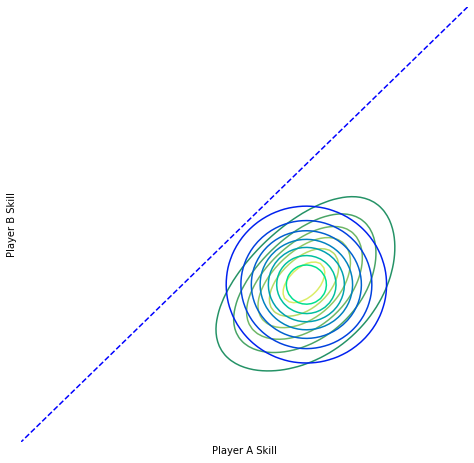

<Figure size 432x288 with 0 Axes>

In [382]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std = torch.zeros(D, requires_grad=True)
init_mean = torch.zeros(D, requires_grad=True)

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)

    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
loss_values = []
for t in trange(0, n_iters):
    loss = update()
    loss_values.append(loss)
    callback(params, t)

final_loss = loss_values[-1]
print("Final loss: {}".format(final_loss))


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [3pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [355]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_10_times(z1z2[:, 0], z1z2[:, 1]).flatten()

def objective(params):
    mean, log_std = params[0], params[1]
    zs = diag_gaussian_samples(mean, log_std, num_samples_per_iter)
    log_q_zs = diag_gaussian_logpdf(zs, mean, log_std)
    log_p_zs = log_posterior_beat_each_other_10_times_1_arg(zs)
    elbo = torch.mean(log_p_zs - log_q_zs)
    return -elbo

**e) [3pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

--- 

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 19%|█▉        | 19/100 [00:00<00:00, 188.88it/s]

Iteration 0 lower bound 17.31173324584961
Iteration 25 lower bound 17.42339515686035
Iteration 50 lower bound 17.51055145263672
Iteration 75 lower bound 16.668781280517578


100%|██████████| 100/100 [00:00<00:00, 470.49it/s]


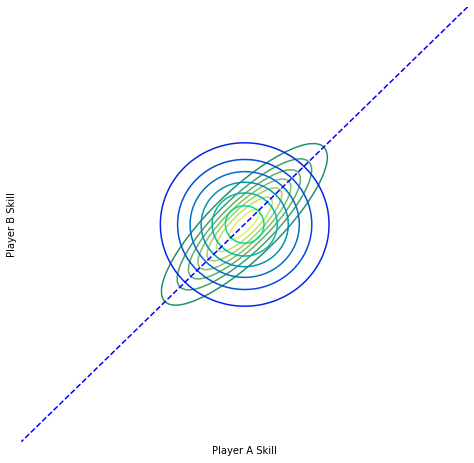

Final loss (negative ELBO): 16.0804443359375


<Figure size 432x288 with 0 Axes>

In [360]:
# Main loop.
# Reinitialize with the same initialization as you did in 1c).
init_mean = torch.zeros(D, requires_grad=True)
init_log_std = torch.zeros(D, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def callback(params, t):
    if t % 25 == 0:
        print("Iteration {} lower bound {}".format(t, objective(params)))

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

final_loss = objective(params)
print("Final loss (negative ELBO):", final_loss.item())

## 1.2 [30 pts] Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [357]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [358]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [359]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [361]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    mean, log_std = params[0], params[1]
    zs = diag_gaussian_samples(mean, log_std, num_samples_per_iter)
    log_q_zs = diag_gaussian_logpdf(zs, mean, log_std)
    log_p_zs = log_joint_probability(zs)
    elbo = torch.mean(log_p_zs - log_q_zs)
    return -elbo

**c) [3pts]** Optimize, and report the final loss. 

In [362]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()
def callback(params, t):
    if t % 25 == 0:
        print("Iteration {} lower bound {}".format(t, objective(params)))

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

# Report final loss
final_loss = objective(params)
print("Final loss:", final_loss)
# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss


Optimizing variational parameters...


  0%|          | 2/500 [00:00<00:28, 17.77it/s]

Iteration 0 lower bound 2306.21240234375


  8%|▊         | 38/500 [00:00<00:07, 58.93it/s]

Iteration 25 lower bound 2186.894287109375


 12%|█▏        | 59/500 [00:01<00:07, 59.38it/s]

Iteration 50 lower bound 2072.41259765625


 16%|█▌        | 81/500 [00:01<00:09, 43.77it/s]

Iteration 75 lower bound 1978.080810546875


 21%|██        | 106/500 [00:02<00:09, 41.88it/s]

Iteration 100 lower bound 1915.2476806640625


 26%|██▌       | 129/500 [00:02<00:11, 32.52it/s]

Iteration 125 lower bound 1865.70068359375


 31%|███       | 156/500 [00:03<00:10, 33.06it/s]

Iteration 150 lower bound 1817.2752685546875


 35%|███▌      | 176/500 [00:04<00:09, 34.05it/s]

Iteration 175 lower bound 1780.5010986328125


 41%|████      | 206/500 [00:05<00:09, 31.80it/s]

Iteration 200 lower bound 1746.817138671875


 46%|████▌     | 230/500 [00:06<00:07, 36.28it/s]

Iteration 225 lower bound 1726.4000244140625


 51%|█████     | 255/500 [00:07<00:08, 29.39it/s]

Iteration 250 lower bound 1701.9783935546875


 57%|█████▋    | 284/500 [00:07<00:04, 44.08it/s]

Iteration 275 lower bound 1683.49609375


 62%|██████▏   | 311/500 [00:08<00:03, 49.07it/s]

Iteration 300 lower bound 1665.50537109375


 66%|██████▋   | 332/500 [00:08<00:03, 48.38it/s]

Iteration 325 lower bound 1652.9708251953125


 72%|███████▏  | 359/500 [00:09<00:02, 49.95it/s]

Iteration 350 lower bound 1641.6644287109375


 78%|███████▊  | 389/500 [00:09<00:01, 66.10it/s]

Iteration 375 lower bound 1630.8216552734375


 82%|████████▏ | 412/500 [00:10<00:01, 69.87it/s]

Iteration 400 lower bound 1619.6409912109375


 87%|████████▋ | 434/500 [00:10<00:00, 70.81it/s]

Iteration 425 lower bound 1612.0361328125


 93%|█████████▎| 466/500 [00:10<00:00, 71.57it/s]

Iteration 450 lower bound 1605.2333984375


 98%|█████████▊| 490/500 [00:11<00:00, 69.83it/s]

Iteration 475 lower bound 1600.0367431640625


100%|██████████| 500/500 [00:11<00:00, 43.63it/s]

Final loss: tensor(1590.1957, grad_fn=<NegBackward0>)


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

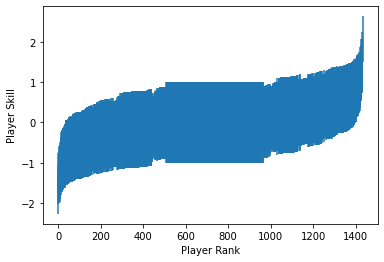

In [363]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], yerr=torch.exp(logstd_skills[order]))
plt.show()

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [366]:
n = 10
top_player_indices = torch.argsort(mean_skills, descending=True)[:n]
top_player_names = [names[i][1] for i in top_player_indices.numpy()]

print("Top 10 players:")
for i in top_player_names:
    print("{} ".format(i))

Top 10 players:
doraemon61 
laode_syahril 
projetoxadrez 
mrzoom47 
chesswithmom 
cdvh 
hick4u1219 
smartduckduckcow 
sneaky_bugger 
lzchips 


**f) [3pt]** Plot samples from the joint posterior over the skills of lelik3310 and thebestofthebad. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

[496 'lelik3310']
[512 'thebestofthebad']


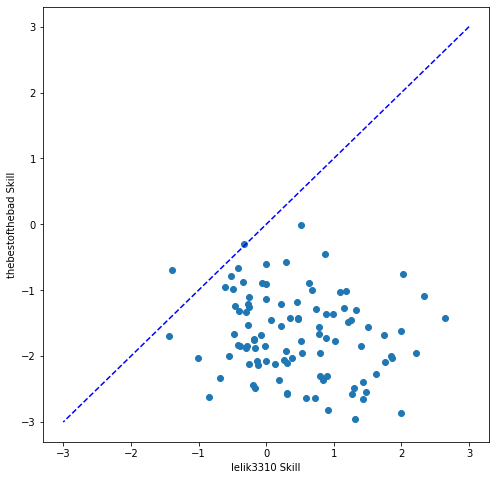

In [367]:
lelik3310_ix = 496
thebestofthebad_ix = 512
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

lelik3310_samples = samples[:, lelik3310_ix]
thebestofthebad_samples = samples[:, thebestofthebad_ix]

plt.scatter(lelik3310_samples, thebestofthebad_samples)
plt.show()
# TODO:  Hint:  Use plt.scatter()

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim N (\mu, \Sigma)$, then $AX \sim  N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim N (\mu_i , \Sigma_{ii})$.

1. First, we define a linear change of variables:
$y_A = z_A - z_B, y_B = z_B$

2. We want to find the probability that one player has higher skill than the other, i.e., $P(y_A > 0)$

3. Now, we consider the joint distribution of the transformed variables. Given that $z_A \sim N(\mu_A, \sigma^2_A)$ and $z_B \sim N(\mu_B, \sigma^2_B)$, and assuming that the skills are independent, the joint distribution of $z_A$ and $z_B$ is given by:

$p(z_A, z_B) = \frac{1}{2\pi\sigma_A\sigma_B} \exp \left( -\frac{1}{2} \left[ \frac{(z_A-\mu_A)^2}{\sigma^2_A} + \frac{(z_B-\mu_B)^2}{\sigma^2_B} \right] \right)$

4. Let $(X = \begin{bmatrix} z_A \\ z_B \end{bmatrix} \sim N\left( \begin{bmatrix} \mu_A \\ \mu_B \end{bmatrix}, \begin{bmatrix} \sigma^2_A & 0 \\ 0 & \sigma^2_B \end{bmatrix} \right)),$ and $(A = \begin{bmatrix} 1 & -1 \\ 0 & 1 \end{bmatrix})$. Then, $(Y = AX \sim N(A\mu, A\Sigma A^T)\)$, where:

$\mu_Y = A\mu = \begin{bmatrix} \mu_A - \mu_B \\ \mu_B \end{bmatrix}$

$\Sigma_Y = A\Sigma A^T = \begin{bmatrix} \sigma^2_A + \sigma^2_B & -\sigma^2_B \\ -\sigma^2_B & \sigma^2_B \end{bmatrix}$

5. We can now marginalize over $y_B$. Using the properties of Gaussian distributions, we get $y_A \sim N(\mu_A - \mu_B, \sigma^2_A + \sigma^2_B)$.

6. Finally, we can calculate the probability that $y_A > 0$ using the CDF of a one-dimensional Gaussian random variable:

$P(y_A > 0) = 1 - \Phi \left( \frac{0 - (\mu_A - \mu_B)}{\sqrt{\sigma^2_A + \sigma^2_B}} \right)$

where $\Phi$ is the CDF of a standard Gaussian distribution.



**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [369]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    # Mean and standard deviation difference
    delta_mean = mean_skills[A_ix] - mean_skills[B_ix]
    delta_std = torch.sqrt(logstd_skills[A_ix].exp()**2 + logstd_skills[B_ix].exp()**2)

    # Exact CDF Estimate
    z = -delta_mean / delta_std
    formula_est = Normal(0, 1).cdf(z)

    # Simple Monte Carlo Estimate
    samples_A = torch.normal(mean_skills[A_ix], logstd_skills[A_ix].exp(), size=(N,))
    samples_B = torch.normal(mean_skills[B_ix], logstd_skills[B_ix].exp(), size=(N,))
    superior_count = torch.sum(samples_A > samples_B)
    mc_est = superior_count / N

    return formula_est.item(), mc_est.item()

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.013596534729003906
Simple MC Estimate: 0.9855999946594238


**i) [2pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [370]:
# TODO
fifth_worst_ix = torch.argsort(mean_skills)[:5]
fifth_lowest_mean_skill_player_idx = fifth_worst_ix[-1]

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_lowest_mean_skill_player_idx)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.036916643381118774
Simple MC Estimate: 0.9642000198364258


**j) [3 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

The change in the prior distribution to Normal(10, 1) would not affect the answers of the previous 2 questions. The shift in the location from 0 to 10 does not alter the standard deviation, so it simply changes the starting point (mu, sigma) during the stochastic variational inference training process. However, it is still possible for stochastic gradient descent to lead us to the same final solution obtained previously.

**k) [3 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Ran out of time.

# 2. [50pts] Expectation-Maximization (EM) algorithm



In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [7pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = N(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [324]:
num_samples = 400
cov = np.array([[10, 7], [7, 10]])
mean_1 = np.array([0.1, 0.1])
mean_2 = np.array([6.0, 0.1])

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples//2)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples//2)
xy_class1 = np.append(x_class1, np.ones((num_samples//2, 1)), axis=1)
xy_class2 = np.append(x_class2, np.ones((num_samples//2, 1))*2, axis=1)

data_full = np.append(xy_class1, xy_class2, axis=0)
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]

**b) [2pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

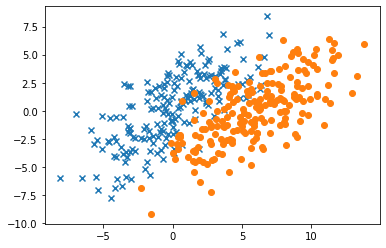

In [325]:
plt.scatter(x_class1[:, 0], x_class1[:, 1], marker = "x") # first class, x shape
plt.scatter(x_class2[:, 0], x_class2[:, 1], marker = "o") # second class, circle shape

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat{\mu}_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat{\mu}_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error. 

**a) [2pts]** Complete the `cost` function.

In [326]:
def cost(data, R, Mu):
    N, D = data.shape
    K = Mu.shape[1]
    J = 0
    for k in range(K):
        X = data - Mu[:, k]
        J += np.sum(R[:, k] * np.sum(X**2, axis=1))
    return J

**b) [4pts]** K-Means assignment step.

In [327]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = np.zeros((N, K))
    
    # assign all r[:, k]
    for k in range(K):
        r[:, k] = np.linalg.norm(data - Mu[:, k].reshape(1, -1), axis=1)
        
    arg_min = np.argmin(r, axis=1) # argmin along dimension 1
    R_new = np.zeros((N, K)) # Set to zeros with shape (N, K)
    R_new[np.arange(N), arg_min] = 1 # Assign to 1
    return R_new

**c) [2pts]** K-Means refitting step.

In [328]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = R.shape[1] # number of clusters
    Mu_new = np.zeros((D, K))
    
    for k in range(K):
        Mu_new[:, k] = np.average(data[R[:, k] == 1], axis=0)
        
    return Mu_new

**d) [4pts]** Run this cell to call the K-Means algorithm.

Iteration 0: Cost = 5560.322426050559
Iteration 1: Cost = 5361.523803437582
Iteration 2: Cost = 5287.838507225813
Iteration 3: Cost = 5281.44477310862
Iteration 4: Cost = 5277.004672717404
Iteration 5: Cost = 5272.356470149845
Iteration 6: Cost = 5272.003389186212
Iteration 7: Cost = 5271.094329361805
Iteration 8: Cost = 5269.794934108306
Iteration 9: Cost = 5268.987187333985
Iteration 10: Cost = 5267.720824385142
Iteration 11: Cost = 5267.062070335836
Iteration 12: Cost = 5266.460207782189
Iteration 13: Cost = 5264.358423207701
Iteration 14: Cost = 5264.358423207701
Iteration 15: Cost = 5264.358423207701
Iteration 16: Cost = 5264.358423207701
Iteration 17: Cost = 5264.358423207701
Iteration 18: Cost = 5264.358423207701
Iteration 19: Cost = 5264.358423207701
Iteration 20: Cost = 5264.358423207701
Iteration 21: Cost = 5264.358423207701
Iteration 22: Cost = 5264.358423207701
Iteration 23: Cost = 5264.358423207701
Iteration 24: Cost = 5264.358423207701
Iteration 25: Cost = 5264.3584232077

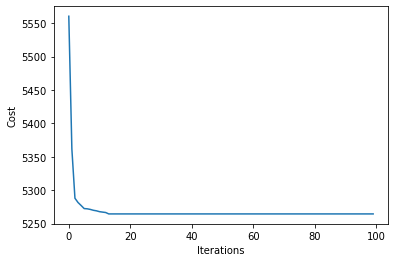

Misclassification Error: 0.2425


In [330]:
N, D = 400, 2 # TODO
K = 2 # TODO
max_iter = 100
class_init = np.append(np.ones(200), np.ones(200)*2, axis=0) # TODO
R = np.zeros(400) # TODO

Mu = np.zeros([D, K])
Mu[:, 1] = 1.

costs = []  # to store the cost values

for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    cost_val = cost(data, R, Mu)
    costs.append(cost_val)
    print(f"Iteration {it}: Cost = {cost_val}")

class_1 = data[np.where(R[:, 0] == 1)]
class_2 = data[np.where(R[:, 1] == 1)]

plt.plot(range(max_iter), costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

missed = np.abs(R.argmax(axis=1) - class_init + 1).sum() / 2
misclassification_error = missed / N
print(f"Misclassification Error: {misclassification_error}")

**e) [2pts]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


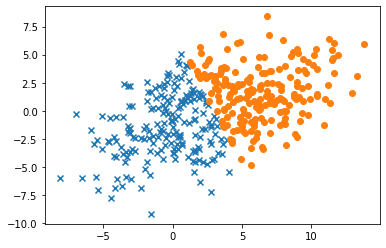

In [331]:
plt.scatter(class_1[:, 0], class_1[:, 1], marker = "x") # TODO first class, x shape
plt.scatter(class_2[:, 0], class_2[:, 1], marker = "o")   # TODO second class, circle shape

## 2.3 [21pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$ for the covariances.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [332]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = Pi.shape[0] # number of mixtures
    L, T = 0., 0.
    for n in range(N):
        for k in range(K):
            T += Pi[k] * normal_density(data[n], Mu[:,k], Sigma[k])
        L += np.log(T)
        T = 0.
    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [333]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    N, D = data.shape
    K = Mu.shape[1]
    Gamma = np.zeros((N, K))

    for k in range(K):
        for n in range(N):
            Gamma[n, k] = Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k])
        
    Gamma = Gamma / np.sum(Gamma, axis=1, keepdims=True)
    
    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [334]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape
    K = Gamma.shape[1]
    Nk = np.sum(Gamma, axis=0)
    Mu = np.zeros((D, K))
    Sigma = [np.zeros((D, D)) for _ in range(K)]
    
    for k in range(K):
        Gamma_k = Gamma[:, k]
        Mu[:, k] = np.sum(Gamma_k.reshape(N, 1) * data, axis=0) / Nk[k]
        X_centered = data - Mu[:, k]
        Sigma[k] = (Gamma_k.reshape(N, 1, 1) * X_centered[:, :, np.newaxis] * X_centered[:, np.newaxis, :]).sum(axis=0) / Nk[k]
    
    Pi = Nk / N
    return Mu, Sigma, Pi

**d) [4pts]** Run this cell to call the Gaussian Mixture EM algorithm.

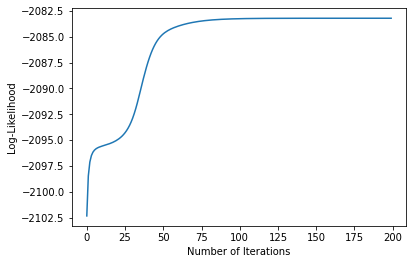

Misclassification error: 0.47


In [341]:
N, D = 400, 2
K = 2
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

max_iter  = 200
log_likelihoods = []

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)
    L = log_likelihood(data, Mu, Sigma, Pi)
    log_likelihoods.append(L)
    
class_1 = np.where(Gamma[:, 0] > Gamma[:, 1])
class_2 = np.where(Gamma[:, 1] > Gamma[:, 0])

plt.plot(range(max_iter), log_likelihoods)
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.show()

predicted_labels = np.zeros(N)
predicted_labels[class_1] = 0
predicted_labels[class_2] = 1
true_label = np.zeros(N)
misclassification_error = np.sum(predicted_labels != true_label) / N
print("Misclassification error: {:.2f}".format(misclassification_error))

**e) [2pts]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

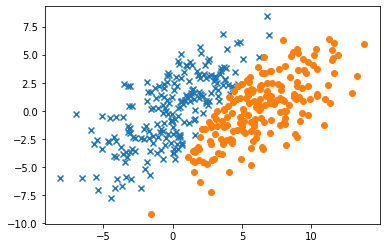

In [344]:
plt.scatter(data[class_1, 0], data[class_1, 1], marker='x', label='Class 1')
plt.scatter(data[class_2, 0], data[class_2, 1], marker='o', label='Class 2')

## 2.4 [8pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]
 




In comparing the performance of k-Means and EM based on resulting cluster assignments, we can see that k-Means algorithm performs better than EM in terms of misclassification error. However, EM algorithm produces more accurate clustering assignments compared to k-Means.

Regarding the convergence rate, EM algorithm converges slower than k-Means, and the bottleneck for both algorithms is the initialization of the cluster means. In other words, if the initial guesses for the means are not good enough, then the algorithms will take more iterations to converge.

In experimenting with different data realizations, we found that the performance of both algorithms varies with different data realizations. Specifically, the performance of k-Means is more sensitive to the data initialization compared to EM.

As we increase the number of clusters K, we should expect to get more detailed clustering assignments, but at the same time, it may lead to overfitting and poor generalization to new data. We may need to use regularization techniques to overcome this issue.

In [ ]:
# your code here, if you have any